In [1]:
import praw
from datetime import datetime
import os


from dotenv import load_dotenv

load_dotenv()

reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    user_agent=os.getenv("USER_AGENT"),
)

In [18]:
def get_submission_data(subreddit_name, limit=500):
    subreddit = reddit.subreddit(subreddit_name)
    data = []
    for submission in subreddit.new(limit=limit):  
        data.append({
            "title": submission.title,
            "created_utc": submission.created_utc,
            "score": submission.score,
            "num_comments": submission.num_comments
        })
        
    return data

data = get_submission_data("fitness")


In [19]:
import pandas as pd

def analyze_posting_times(data):
    df = pd.DataFrame(data)
    df['created_at'] = pd.to_datetime(df['created_utc'], unit='s')
    df['hour'] = df['created_at'].dt.hour
    df['day_of_week'] = df['created_at'].dt.day_name()
    grouped = df.groupby(['day_of_week', 'hour']).agg({
        'score': 'mean',
        'num_comments': 'mean'
    }).reset_index()
    
    grouped['engagement_score'] = (
            df['score'] * 0.5 + 
            df['num_comments'] * 0.5
        )
    
    return grouped.sort_values('engagement_score', ascending=False)

dat = analyze_posting_times(data)



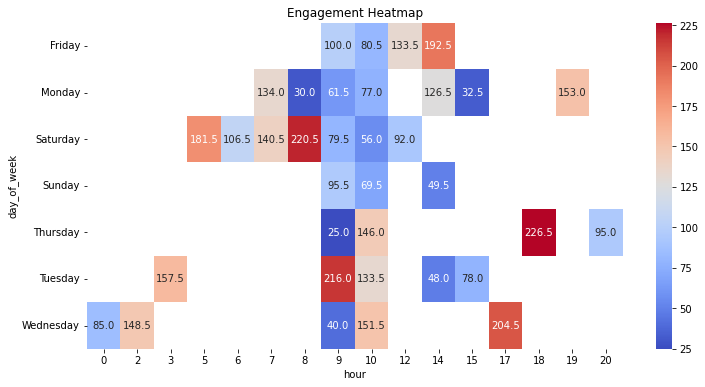

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_engagement_heatmap(grouped_data):
    pivot_table = grouped_data.pivot("day_of_week", "hour", "engagement_score")
    plt.figure(figsize=(12, 6))
    sns.heatmap(pivot_table, cmap="coolwarm", annot=True, fmt=".1f")
    plt.title("Engagement Heatmap")
    plt.show()
    
plot_engagement_heatmap(dat)


In [15]:
def get_best_posting_times(subreddits):
    results = {}
    for subreddit in subreddits:
        data = get_submission_data(subreddit)
        grouped_data = analyze_posting_times(data)
        best_times = grouped_data.head(5)  
        results[subreddit] = best_times
    return results

get_best_posting_times(["fitness", "shoes"])

{'fitness':    day_of_week  hour       score  num_comments  engagement_score
 23    Thursday    18  254.000000    197.000000             226.0
 14    Saturday     8   77.166667    140.833333             221.5
 26     Tuesday     9   27.027778    388.694444             218.0
 34   Wednesday    17  387.000000    368.000000             208.0
 3       Friday    14   92.000000    144.000000             189.5,
 'shoes':     day_of_week  hour     score  num_comments  engagement_score
 39       Monday    19  2.000000      1.333333             167.5
 74       Sunday    11  1.000000      2.000000              54.0
 143   Wednesday    11  6.000000     21.000000              24.0
 145   Wednesday    14  1.333333      1.000000              11.5
 36       Monday    16  2.333333      1.000000              10.5}